In [15]:
import psycopg2
import os
from os.path import join, dirname
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import csv
import hashlib
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support, roc_curve, auc
import scipy.stats as stats
import statsmodels.api as sm
from glm.glm import GLM
from glm.families import Gaussian, Bernoulli, Poisson, Exponential
import statsmodels.formula.api as smf
import seaborn as sns

linear_model = GLM(family=Gaussian())

dotenv_path = join(dirname(os.path.abspath('')), 'analysis', '.env')
load_dotenv(dotenv_path)

True

# Initializing Database

In [43]:
#you will have to set up postgres and load the attached.sql file as the database with name 'sero_data2'
#you will have the load the password and username from a .env file with the information about how to connect to the database
conn = psycopg2.connect(host="localhost", port = 5432, database="sero_data2", user="postgres", password=os.getenv('PASSWORD'))

# Create a cursor object
cur = conn.cursor()

def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table

#start and end dates for the without and with tool stages
INIT_DATE1 = '2021-06-18 07:04:34.056486'
END_DATE1 = '2021-07-2 07:04:34.056486'

INIT_DATE2 = '2021-07-9 04:04:34.056486'
END_DATE2 = '2021-07-23 07:04:34.056486'

# Load information about extra reviews added

In [44]:
names = [
    'reviewer2',
    'reviewer3',
    'reviewer4',
    'reviewer5',
    'reviewer6',
    'reviewer7',
    'reviewer8',
    'reviewer9',
    'reviewer10',
    'reviewer11',
    'reviewer12',
    'reviewer13',
    'reviewer14',
    'reviewer15',
    'reviewer16',
    'reviewer17',
    'reviewer18',
    'reviewer19',
    'reviewer20'
]

reviewer_must_vote_names = [
    'reviewer2',
    'reviewer3',
    'reviewer5',
    'reviewer1',
    'reviewer14',
    'reviewer8',
]

csv_filename = './abstracts_for_review_shuffled.csv'

csvfile = open(csv_filename, 'r', encoding="utf8")
field_names = ("title","authors","abstract", "published_year", 'published_month', 'journal', "volume", "issue", "pages", "accession_number", "doi", 'ref', 'covidence_number', 'study', 'notes', 'tags', 'label', 'index')
reader = csv.DictReader( csvfile, field_names)

hash_to_label = {}

extraction_excluded_hashes = []

#indices for the reviews which were later found to be excluded in extraction
excluded_indices = [36,
                    21,
                    86,
                    94,
                    44,
                    57,
                    26,
                    27,
                    68]

def prepare_abstract(title, abstract):
    if len(title) == 0:
        text = abstract
    else:
        if title[-1] != '.':
            title = title + '.'
        if len(abstract) > 0:
            text = title + ' ' + abstract
        else:
            text = title

    text = text.replace('<h4>', ' ')
    text = text.replace('</h4>', ' ')
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    
    return text
    

first_line = True    
for i, row in enumerate(reader):

    if first_line:
            first_line = False
            continue
    if not row['title']:
            continue


    title = row['title']
    abstract = row['abstract']
    fixed_title = prepare_abstract(title, '')
    title_hash = str(hashlib.sha256(fixed_title.encode('utf-8')).hexdigest())
    
    hash_to_label[title_hash] = {}
    
    hash_to_label[title_hash]['uncleaned'] = int(row['label'])
    
    hash_to_label[title_hash]['cleaned'] = int(row['label']) if int(row['index']) not in excluded_indices else 0
#     if int(row['index']) in excluded_indices:
#         extraction_excluded_hashes.append(title_hash)
    
    hash_to_label[title_hash]['title'] = row['title']
    hash_to_label[title_hash]['abstract'] = row['abstract']
    hash_to_label[title_hash]['index'] = row['index']
    hash_to_label[title_hash]['url'] = row['doi']
    
for title_hash, label_info in hash_to_label.items():
    prediction_query = "SELECT * FROM predictions WHERE title_hash = '{}'".format(title_hash)
    tab = create_pandas_table(prediction_query)
    label_info['prediction'] = tab.iloc[0].inclusion_likelihood

In [18]:
def get_repeats(fake_only, single_person = None, density = False, alpha = 0.7, gamma = True, filter_clean = True, plot = True):
    if(single_person is not None):
        names_to_check = names[single_person: single_person + 1]
    else:
        names_to_check = names

    duplicate_count = 0
    dup_sets = []

    for name in names_to_check:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1
#         query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}' and vote = 'YES'".format(name, INIT_DATE, END_DATE)
        query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}'".format(name, INIT_DATE, END_DATE)
        tab = create_pandas_table(query)
        tab = tab.loc[tab['had_abstract'] == True]
        tab = tab.loc[tab['has_prediction'] == False]
        
        if(filter_clean):
            tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
        if(fake_only):
            tab = tab.loc[tab['fake_review_id'].notnull()]
            
        unique_a = set(tab.title_hash.unique())
        
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
        
        
        query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}'".format(name, INIT_DATE, END_DATE)
        tab = create_pandas_table(query)
        tab = tab.loc[tab['had_abstract'] == True]
        tab = tab.loc[tab['has_prediction'] == True]
        
        if(filter_clean):
            tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
        if(fake_only):
            tab = tab.loc[tab['fake_review_id'].notnull()]
            
        unique_b = set(tab.title_hash.unique())
        
        inter = unique_a.intersection(unique_b)
        
        duplicate_count += len(inter)
        dup_sets.append(inter)
    
    print(duplicate_count)
    return dup_sets
    
dup_sets = get_repeats(True)

170


In [19]:
#time to classify

def get_time_bins(with_prediction, fake_only, single_person = None, density = False, alpha = 0.7, gamma = True, filter_clean = True, plot = True, dup_sets = None, vote_type = None):
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1

    if(dup_sets is None):
        dup_sets = [set() for i in range(len(names))]
    
    if(single_person is not None):
        names_to_check = names[single_person: single_person + 1]
    else:
        names_to_check = names

    times = []

    for name, ds in zip(names_to_check, dup_sets):
        query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}'".format(name, INIT_DATE, END_DATE)
        
        if(vote_type is not None):
            query += " AND vote='{}'".format('YES')
    
        tab = create_pandas_table(query)
        tab['time_taken'] = tab['created_at'] - tab['created_at'].shift(1)
        tab = tab.loc[tab['had_abstract'] == True]
        tab = tab.loc[tab['has_prediction'] == with_prediction]
        tab = tab.loc[tab['time_taken'] > (datetime(2020,1,1) - datetime(2020, 1,1 ))]
        tab = tab.loc[tab['time_taken'] < (datetime(2020,1,1,1,3,1) - datetime(2020, 1,1,1,1,1))]
        
        if(filter_clean):
            tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
        if(fake_only):
            tab = tab.loc[tab['fake_review_id'].notnull()]

        tab = tab[~tab['title_hash'].isin(ds)]
            
        if(len(tab['time_taken']) > 0):
            times_list = tab['time_taken'].dt.total_seconds().tolist()
            times_list
            times.extend(times_list)
    
    n = len(times)
    if(plot):
        plt.hist(times, bins = 80, alpha = alpha, density = True)
        if(gamma):
            x = np.linspace(0, 60, 400)
            shape, loc, scale=stats.lognorm.fit(times,floc=0)
            y = stats.lognorm.pdf(x, shape, loc, scale)
            
            plt.plot(x, y)


        title = 'With tool: {}, fake_only: {}, single_person: {}, n = {}'.format(with_prediction, fake_only, single_person, n)
        print(title)
        print('Mean time(s): {}, Std time(s): {}, n = {}, s.e: {}'.format(np.mean(times), np.std(times), n, stats.sem(times)))
        print(np.sum(np.array(times) > 60))
    
    return times #np.log(times)
    
    


With tool: False, fake_only: False, single_person: None, n = 2812
Mean time(s): 21.519909472617357, Std time(s): 22.35923200630029, n = 2812, s.e: 0.42172219621831114
219
With tool: True, fake_only: False, single_person: None, n = 2936
Mean time(s): 14.373750857970029, Std time(s): 17.8618947188384, n = 2936, s.e: 0.3297034354509609
108


<ipython-input-20-97dbb87e4ad7>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])


Ttest_indResult(statistic=13.349636475712183, pvalue=5.1343252328603995e-40)


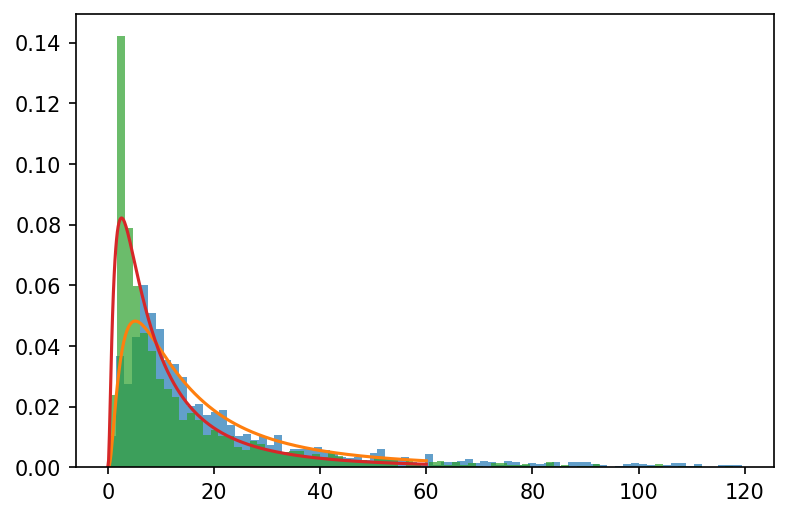

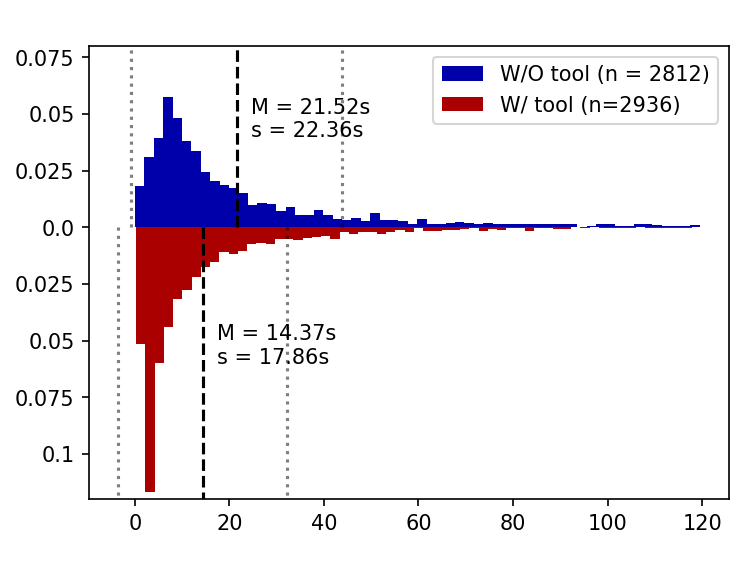

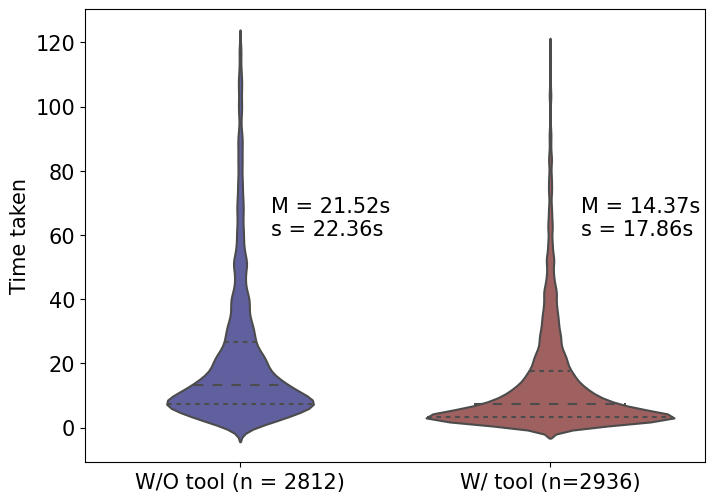

In [20]:
plt.figure(dpi = 150)
times_a = get_time_bins(False, False, None, True)
times_b = get_time_bins(True, False, None, True)
# plt.title('Normalized time taken for abstract screen (fake + real)')
plt.figure(dpi = 150, figsize = (5.5,4))
n_bins = 60
plt.hist(times_a, bins = n_bins, density = True)
counts, _, _ = plt.hist(times_b, bins = n_bins, density = True)
_, y_max = plt.gca().get_ylim()
plt.clf()
plt.hist(times_a, bins = n_bins, density = True, color = '#0000aa')
plt.hist(times_b, bins = n_bins, bottom = -counts, density = True, color='#aa0000')

y_max = 0.08
y_min = -.12

plt.gca().set_ylim((y_min , y_max))


ticks =  plt.gca().get_yticks()
plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])

plt.title(' ')
# plt.xlabel('Time taken per abstract (s)')
plt.legend(['W/O tool (n = {})'.format(len(times_a)), 'W/ tool (n={})'.format(len(times_b))])
plt.xlabel(' ')

plt.plot((np.mean(times_a), np.mean(times_a)), (0, y_max), 'k', linestyle='dashed')
plt.plot((np.mean(times_b), np.mean(times_b)), (0, y_min), 'k', linestyle = 'dashed')

plt.text(np.mean(times_a) + 3, y_max/2, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_a), np.std(times_a)))
plt.text(np.mean(times_b) + 3, y_min/2, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_b), np.std(times_b)))

plt.plot((np.mean(times_a) + np.std(times_a), np.mean(times_a) + np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_a) - np.std(times_a), np.mean(times_a) - np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)

plt.plot((np.mean(times_b) + np.std(times_b), np.mean(times_b) + np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_b) - np.std(times_b), np.mean(times_b) - np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)

plt.figure(figsize = (8, 6), dpi = 100)
ax = sns.violinplot(data = [times_a, times_b], inner='quartile', palette = ['#5555aa', '#aa5555'], bw = 0.1)
ax.set_xticklabels(['W/O tool (n = {})'.format(len(times_a)), 'W/ tool (n={})'.format(len(times_b))])
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.ylabel('Time taken', fontsize = 15)

plt.text(0.1, np.mean(ax.get_ylim()), 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_a), np.std(times_a)), fontsize = 15)
plt.text(1.1, np.mean(ax.get_ylim()), 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_b), np.std(times_b)), fontsize = 15)

print(stats.ttest_ind(times_a, times_b, equal_var = False))

170
With tool: False, fake_only: True, single_person: None, n = 732
Mean time(s): 22.91630246448088, Std time(s): 22.763138871579134, n = 732, s.e: 0.8419251043752569
59
With tool: True, fake_only: True, single_person: None, n = 728
Mean time(s): 14.004180245879123, Std time(s): 18.113893896455338, n = 728, s.e: 0.6718071382012546
25
Ttest_indResult(statistic=8.27411746456688, pvalue=2.996072333950332e-16)


<ipython-input-21-ba9d76a71ea4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])


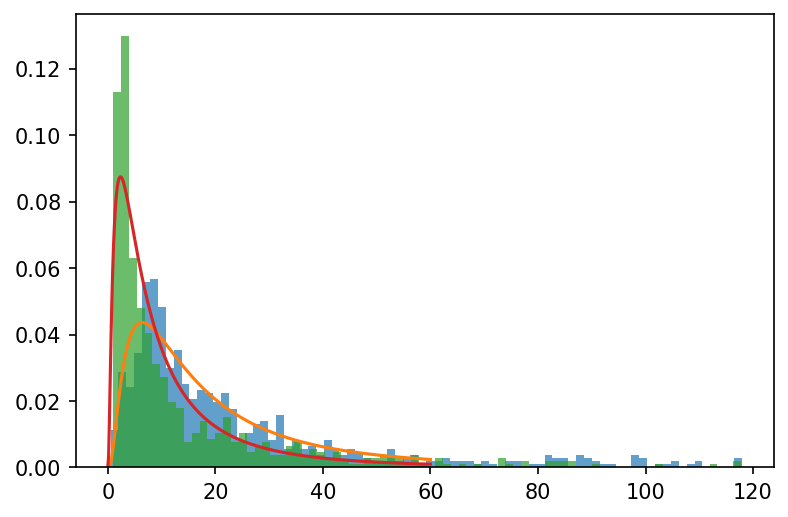

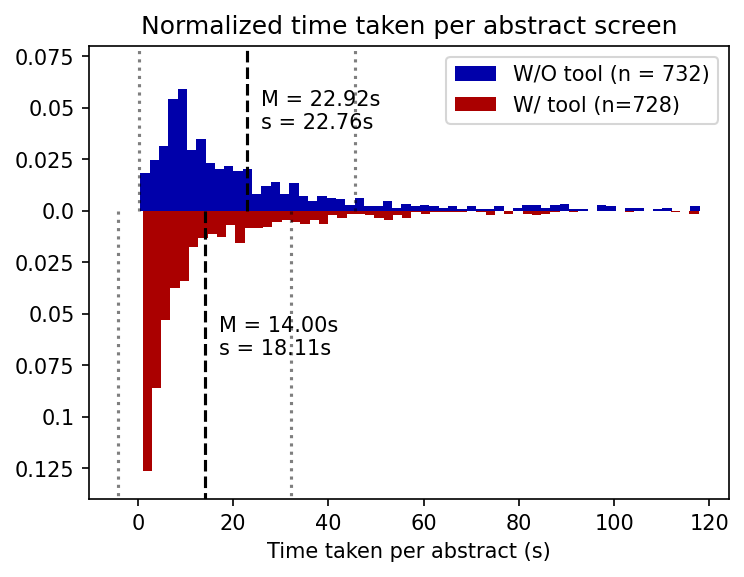

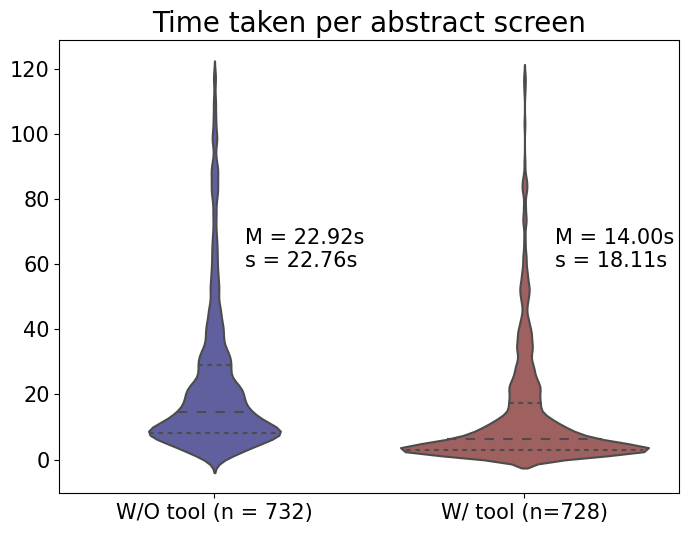

In [21]:
plt.figure(dpi = 150)
dup_sets = get_repeats(True)
times_a = get_time_bins(False, True, None, True, dup_sets = None)
times_b = get_time_bins(True, True, None, True, dup_sets = None)
plt.figure(dpi = 150, figsize = (5.5,4))
n_bins = 60
plt.hist(times_a, bins = n_bins, density = True)
counts, _, _ = plt.hist(times_b, bins = n_bins, density = True)
_, y_max = plt.gca().get_ylim()
plt.clf()
plt.hist(times_a, bins = n_bins, density = True, color = '#0000aa')
plt.hist(times_b, bins = n_bins, bottom = -counts, density = True, color='#aa0000')

y_max = 0.08
y_min = -.14

plt.gca().set_ylim((y_min , y_max))


ticks =  plt.gca().get_yticks()
plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])

plt.title('Normalized time taken per abstract screen')
plt.xlabel('Time taken per abstract (s)')
plt.legend(['W/O tool (n = {})'.format(len(times_a)), 'W/ tool (n={})'.format(len(times_b))])

plt.plot((np.mean(times_a), np.mean(times_a)), (0, y_max), 'k', linestyle='dashed')
plt.plot((np.mean(times_b), np.mean(times_b)), (0, y_min), 'k', linestyle = 'dashed')

plt.text(np.mean(times_a) + 3, y_max/2, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_a), np.std(times_a)))
plt.text(np.mean(times_b) + 3, y_min/2, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_b), np.std(times_b)))

plt.plot((np.mean(times_a) + np.std(times_a), np.mean(times_a) + np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_a) - np.std(times_a), np.mean(times_a) - np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)

plt.plot((np.mean(times_b) + np.std(times_b), np.mean(times_b) + np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_b) - np.std(times_b), np.mean(times_b) - np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)

plt.figure(figsize = (8, 6), dpi = 100)
plt.title('Time taken per abstract screen', fontsize = 20)
ax = sns.violinplot(data = [times_a, times_b], inner='quartile', palette = ['#5555aa', '#aa5555'], bw = 0.1)
ax.set_xticklabels(['W/O tool (n = {})'.format(len(times_a)), 'W/ tool (n={})'.format(len(times_b))])
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
# plt.ylabel('Time taken', fontsize = 15)

plt.text(0.1, np.mean(ax.get_ylim()), 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_a), np.std(times_a)), fontsize = 15)
plt.text(1.1, np.mean(ax.get_ylim()), 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_b), np.std(times_b)), fontsize = 15)

print(stats.ttest_ind(times_a, times_b, equal_var = False))

With tool: False, fake_only: False, single_person: None, n = 116
Mean time(s): 44.99592397413794, Std time(s): 31.924250682848285, n = 116, s.e: 2.976951726122515
34
With tool: True, fake_only: False, single_person: None, n = 149
Mean time(s): 39.9542147181208, Std time(s): 32.02747889518704, n = 149, s.e: 2.6326425481562263
39
Ttest_indResult(statistic=1.2686587366256445, pvalue=0.20575442508345193)


<ipython-input-22-2d4a7e18e16b>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])


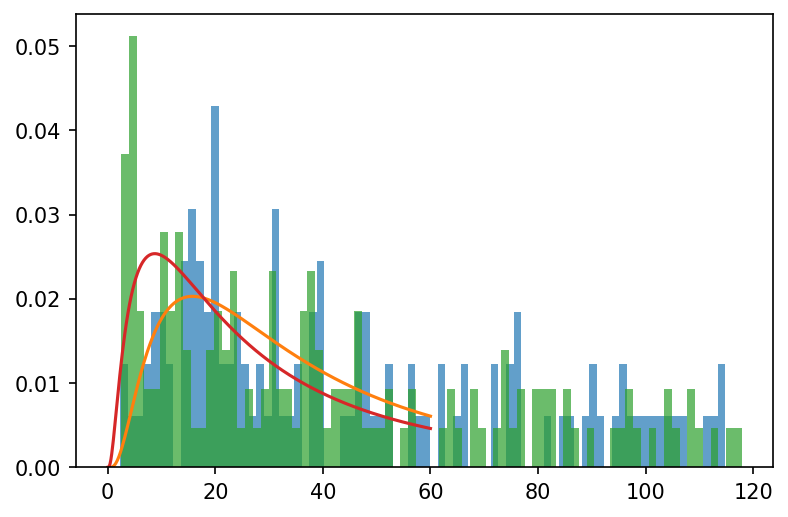

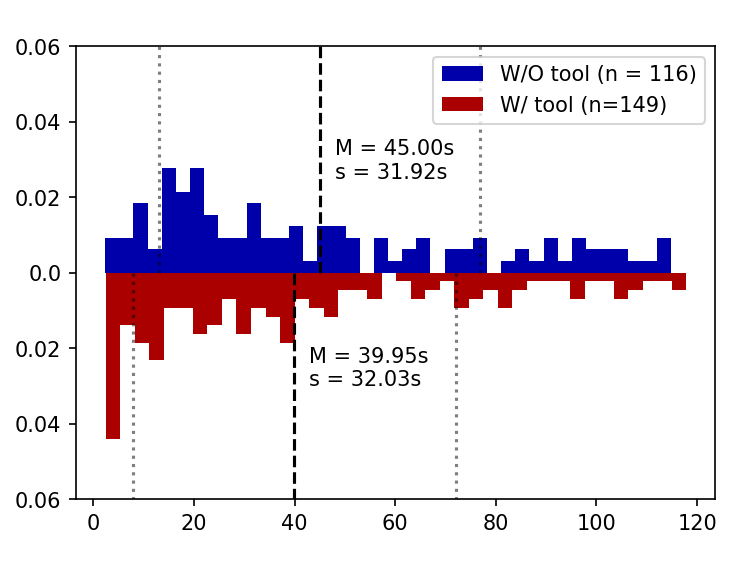

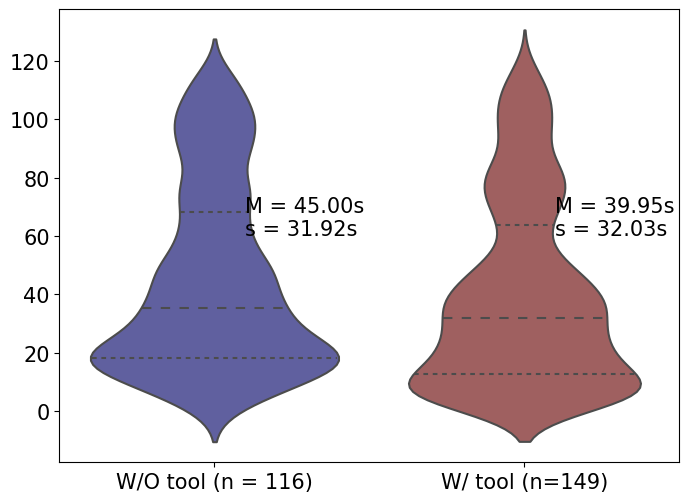

In [22]:
plt.figure(dpi = 150)
times_a = get_time_bins(False, False, None, True, vote_type='YES')
times_b = get_time_bins(True, False, None, True, vote_type = 'YES')
# plt.title('Normalized time taken for abstract screen (fake + real)')
plt.figure(dpi = 150, figsize = (5.5,4))
n_bins = 40
plt.hist(times_a, bins = n_bins, density = True)
counts, _, _ = plt.hist(times_b, bins = n_bins, density = True)
_, y_max = plt.gca().get_ylim()
plt.clf()
plt.hist(times_a, bins = n_bins, density = True, color = '#0000aa')
plt.hist(times_b, bins = n_bins, bottom = -counts, density = True, color='#aa0000')

y_max = 0.06
y_min = -.06

plt.gca().set_ylim((y_min , y_max))


ticks =  plt.gca().get_yticks()
plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])

plt.title(' ')
# plt.xlabel('Time taken per abstract (s)')
plt.legend(['W/O tool (n = {})'.format(len(times_a)), 'W/ tool (n={})'.format(len(times_b))])
plt.xlabel(' ')

plt.plot((np.mean(times_a), np.mean(times_a)), (0, y_max), 'k', linestyle='dashed')
plt.plot((np.mean(times_b), np.mean(times_b)), (0, y_min), 'k', linestyle = 'dashed')

plt.text(np.mean(times_a) + 3, y_max/2 - 0.005, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_a), np.std(times_a)))
plt.text(np.mean(times_b) + 3, y_min/2, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_b), np.std(times_b)))

plt.plot((np.mean(times_a) + np.std(times_a), np.mean(times_a) + np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_a) - np.std(times_a), np.mean(times_a) - np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)

plt.plot((np.mean(times_b) + np.std(times_b), np.mean(times_b) + np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_b) - np.std(times_b), np.mean(times_b) - np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)

plt.figure(figsize = (8, 6), dpi = 100)
ax = sns.violinplot(data = [times_a, times_b], inner='quartile', palette = ['#5555aa', '#aa5555'], bw = 0.2)
ax.set_xticklabels(['W/O tool (n = {})'.format(len(times_a)), 'W/ tool (n={})'.format(len(times_b))])
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)

plt.text(0.1, np.mean(ax.get_ylim()), 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_a), np.std(times_a)), fontsize = 15)
plt.text(1.1, np.mean(ax.get_ylim()), 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_b), np.std(times_b)), fontsize = 15)

print(stats.ttest_ind(times_a, times_b, equal_var = False))

170
With tool: False, fake_only: True, single_person: None, n = 591
Mean time(s): 24.13015845854484, Std time(s): 22.63331462839079, n = 591, s.e: 0.9317988171853484
49
With tool: True, fake_only: True, single_person: None, n = 586
Mean time(s): 14.572271911262801, Std time(s): 18.12444567267511, n = 586, s.e: 0.7493536028622616
18
Ttest_indResult(statistic=7.993321549633053, pvalue=3.2354555684893297e-15)


<ipython-input-23-726b391c2f88>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])


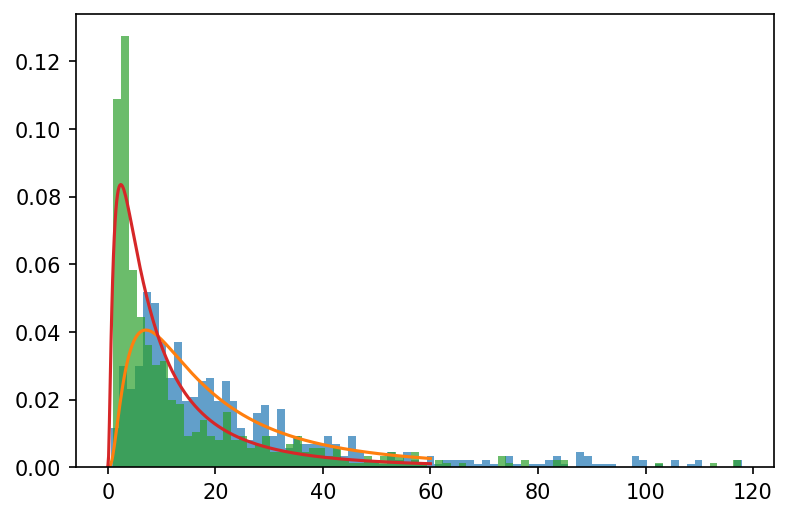

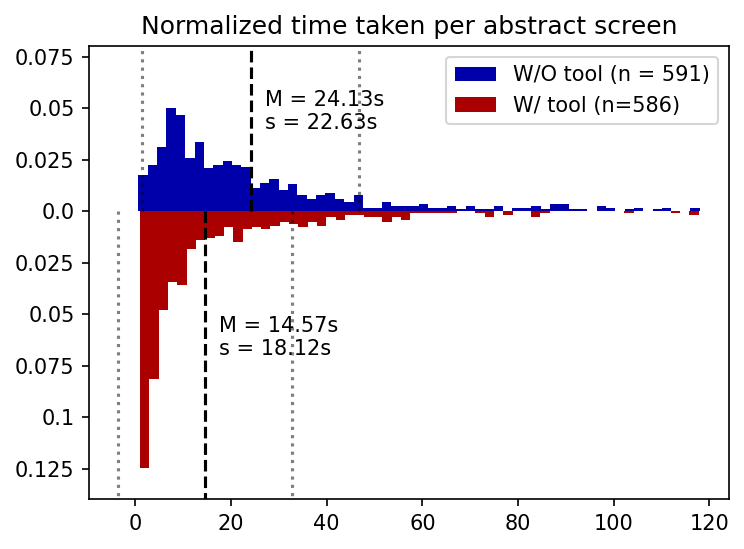

In [23]:
plt.figure(dpi = 150)
dup_sets = get_repeats(True)
times_a = get_time_bins(False, True, None, True, dup_sets = dup_sets)
times_b = get_time_bins(True, True, None, True, dup_sets = dup_sets)
plt.figure(dpi = 150, figsize = (5.5,4))
n_bins = 60
plt.hist(times_a, bins = n_bins, density = True)
counts, _, _ = plt.hist(times_b, bins = n_bins, density = True)
_, y_max = plt.gca().get_ylim()
plt.clf()
plt.hist(times_a, bins = n_bins, density = True, color = '#0000aa')
plt.hist(times_b, bins = n_bins, bottom = -counts, density = True, color='#aa0000')

y_max = 0.08
y_min = -.14

plt.gca().set_ylim((y_min , y_max))


ticks =  plt.gca().get_yticks()
plt.gca().set_yticklabels([round(abs(tick), 3) for tick in ticks])

plt.title('Normalized time taken per abstract screen')
# plt.xlabel('Time taken per abstract (s)')
plt.legend(['W/O tool (n = {})'.format(len(times_a)), 'W/ tool (n={})'.format(len(times_b))])

plt.plot((np.mean(times_a), np.mean(times_a)), (0, y_max), 'k', linestyle='dashed')
plt.plot((np.mean(times_b), np.mean(times_b)), (0, y_min), 'k', linestyle = 'dashed')

plt.text(np.mean(times_a) + 3, y_max/2, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_a), np.std(times_a)))
plt.text(np.mean(times_b) + 3, y_min/2, 'M = {:.2f}s\ns = {:.2f}s'.format(np.mean(times_b), np.std(times_b)))

plt.plot((np.mean(times_a) + np.std(times_a), np.mean(times_a) + np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_a) - np.std(times_a), np.mean(times_a) - np.std(times_a) ), (0, y_max), 'k', linestyle='dotted', alpha = 0.5)

plt.plot((np.mean(times_b) + np.std(times_b), np.mean(times_b) + np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)
plt.plot((np.mean(times_b) - np.std(times_b), np.mean(times_b) - np.std(times_b) ), (0, y_min), 'k', linestyle='dotted', alpha = 0.5)

print(stats.ttest_ind(times_a, times_b, equal_var = False))

# GLM

In [24]:
categories = ['y', 'tool'] + [name.replace(" ", "") for name in names]

data = pd.DataFrame([], columns = categories)

plt.figure(dpi = 100)
for i in range(len(names)):
#     plt.figure(dpi = 150)
    t0 = get_time_bins(False, False, i, True, plot = False)
    
    indicators = [0] + [int(name == names[i]) for name in names]
    def fn(x):
#         return x
        return np.log(x)
    new_rows = [[fn(t0[j])] + indicators for j in range(len(t0))]
    
#     print(new_rows)
    
    new_rows = pd.DataFrame(new_rows, columns = categories)
    
    data = data.append(new_rows)
    
    t1 = get_time_bins(True, False, i, True, plot = False)
    linear_model = GLM(family=Gaussian())
    
    indicators = [1] + [int(name == names[i]) for name in names]
    new_rows = [[fn(t1[j])] + indicators for j in range(len(t1))]
    
    
    new_rows = pd.DataFrame(new_rows, columns = categories)
    
    data = data.append(new_rows)
    
    if(len(t0) > 0 and len(t1) > 0):
        diff = np.mean(t1) - np.mean(t0)
        reduction = 1 - (np.mean(t1)/np.mean(t0))
        print(reduction)
    
for name in names:
    tool_count = len(data.loc[(data[name.replace(" ", "")] == 1) & (data['tool'] == 1)])
    notool_count = len(data.loc[(data[name.replace(" ", "")] == 1) & (data['tool'] == 0)])
    if tool_count == 0 or notool_count == 0:
        del data[name.replace(" ", "")]

print(data.columns)        
        
data.columns = ['y', 'tool'] + ['reviewer' + str(i) for i in range(len(data.columns)-2)]

model = GLM(family=Gaussian())
formula = 'y ~ ' + ' + '.join(data.columns[1:])
model.fit(data, formula=formula)

mod1 = smf.glm(formula=formula, data=data, family=sm.families.Gaussian()).fit()
print(mod1.summary())
print(model.summary())
# 
print((mod1.llf - np.sum(data.y)))
print(len(data.y))
# -21438

0.5147902767354802
-0.6086718817058772
0.5218132847580631
0.29066529874676406
-0.2692833735592479
0.6113352113774307
Index(['y', 'tool', 'reviewer3', 'reviewer4', 'reviewer5', 'reviewer14',
       'reviewer15', 'reviewer17'],
      dtype='object')
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5748
Model:                            GLM   Df Residuals:                     5740
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                         0.87576
Method:                          IRLS   Log-Likelihood:                -7770.8
Date:                Thu, 23 Dec 2021   Deviance:                       5026.9
Time:                        18:16:24   Pearson chi2:                 5.03e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust    

<Figure size 600x400 with 0 Axes>

# Conflict Rates

In [25]:
#Does it reduce the # of conflicts?

#note: Need to filter for <name removed> votes! (not for fake only ones)
def get_conflict_rate(with_prediction, fake_only = True, filter_clean = True):
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1
    
    query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}'".format(INIT_DATE)
    tab = create_pandas_table(query)
    tab = tab.loc[tab['had_abstract'] == True]
    tab = tab.loc[tab['has_prediction'] == with_prediction]
    
    if(fake_only):
        tab = tab.loc[tab['fake_review_id'].notnull()]

    unique_count_in_screen = len(tab.title_hash.unique())


    query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=FALSE AND was_tiebreak=TRUE AND created_at > '{}' AND created_at < '{}'".format(INIT_DATE, END_DATE)
    tab = create_pandas_table(query)
    tab = tab.loc[tab['had_abstract'] == True]
    tab = tab.loc[tab['has_prediction'] == with_prediction]
    
    if(fake_only):
        tab = tab.loc[tab['fake_review_id'].notnull()]
        
    if(filter_clean):
        tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
#     else:
#         tab = tab.loc[~tab['fake_review_id'].notnull()]

    unique_count_in_conflict = len(tab.title_hash.unique())
    
    return unique_count_in_conflict/unique_count_in_screen, unique_count_in_conflict, unique_count_in_screen

print('All abstracts')
res_nt = get_conflict_rate(False, False)
print('Conflict rate without tool: {:.2f}%, n_num: {}, n_den: {}'.format(res_nt[0] * 100, res_nt[1], res_nt[2]))
res_tool = get_conflict_rate(True, False)
print('Conflict rate with tool: {:.2f}%, n_num: {}, n_den: {}'.format(res_tool[0] * 100, res_tool[1], res_tool[2]))

cont_table = np.array([[res_nt[1], res_nt[2] - res_nt[1]], [res_tool[1], res_tool[2] - res_tool[1]]])
print(stats.fisher_exact(cont_table))

print()

print('Fake only')
res_nt = get_conflict_rate(False, True)
print('Conflict rate without tool: {:.2f}%, n_num: {}, n_den: {}'.format(res_nt[0] * 100, res_nt[1], res_nt[2]))
res_tool = get_conflict_rate(True, True)
print('Conflict rate with tool: {:.2f}%, n_num: {}, n_den: {}'.format(res_tool[0] * 100, res_tool[1], res_tool[2]))

cont_table = np.array([[res_nt[1], res_nt[2] - res_nt[1]], [res_tool[1], res_tool[2] - res_tool[1]]])
print(stats.fisher_exact(cont_table))

All abstracts
Conflict rate without tool: 8.52%, n_num: 167, n_den: 1960
Conflict rate with tool: 3.73%, n_num: 89, n_den: 2388
(2.4059419590542497, 3.513972507459383e-11)

Fake only
Conflict rate without tool: 12.25%, n_num: 49, n_den: 400
Conflict rate with tool: 6.25%, n_num: 25, n_den: 400
(2.094017094017094, 0.004725127106210855)


# Full text Success Rates

In [26]:

def filter_votes(tab):

    title_hash_to_votes = {}

    total = len(tab.title_hash.unique())
    
#     print(len(tab))
    tab = tab.sort_values(by=['was_tiebreak'])

    for i in range(len(tab)):
        vote = tab.iloc[i]
        if not vote['title_hash'] in title_hash_to_votes:
            title_hash_to_votes[vote['title_hash']] = {}
        #tie breaks will always go after normal votes
        title_hash_to_votes[vote['title_hash']][vote['reviewer_name']] = {
            'vote': not (vote.vote == 'NO' or vote.vote == 'EXCLUDE'),
            'must_vote': vote.reviewer_name in reviewer_must_vote_names,
            'is_tie_break': vote.was_tiebreak,
            'created_at': vote.created_at,
            'reviewer_name': vote.reviewer_name
        }

    one_vote = 0
    conflicts = 0
    included = 0
    excluded = 0

    conflict_dict = {}
    done_set = set()
    included_set = set()
    already_screened_set = set()
    cant_screen_set = set()

    reviewer_name = 'notarealperson'
    must_vote = False


    for title_hash, vote in title_hash_to_votes.items():
        if(any([vote_info['is_tie_break'] for vote_info in vote.values()])): #tie break
            for vote_info in vote.values():
                if(vote_info['is_tie_break']):
                    done_set.add(title_hash)
                    if(vote_info['vote']):
                        included_set.add(title_hash)
                        included += 1
        else:
            if(len(vote.keys()) > 2): #weird edge case if more than 2 votes, pick first two votes by 'must vote' people
                vote_info_list = sorted(vote.values(), key = lambda x: x['created_at'])
                vote = {}
                #take the first must vote
                for vote_info in vote_info_list:
                    if(vote_info['must_vote']):
                        vote[vote_info['reviewer_name']] = vote_info
                        vote_info_list.remove(vote_info)
                        break
                #take the first item
                vote[vote_info_list[0]['reviewer_name']] = vote_info_list[0]

            if(len(vote.keys()) == 2): #two votes, check if a conflict needs to be resolved or not
                vote_info_list = list(vote.values())
                if(vote_info_list[0]['vote'] == vote_info_list[1]['vote'] and vote_info_list[0]['vote']):
                    done_set.add(title_hash)
                    included_set.add(title_hash)
                    included += 1
                elif(vote_info_list[0]['vote'] == vote_info_list[1]['vote']):
                    done_set.add(title_hash)
                else:
                    conflicts += 1
                    reviewer_names = list(vote.keys())
                    conflict_dict[title_hash] = reviewer_names
            else: #one vote, zero votes can't be in the list
                one_vote += 1
                if(reviewer_name not in vote): #make sure this person hasn't already voted
                    if(list(vote.keys())[0] not in reviewer_must_vote_names and not must_vote):
                        cant_screen_set.add(title_hash)
                else:
                    already_screened_set.add(title_hash)

    done = len(done_set)
    screen = total - done - conflicts - len(cant_screen_set) - len(already_screened_set)
    no_vote = total - done - one_vote - conflicts
    resolve = conflicts

    vote_categories =  {
        'done': done,
        'one_vote': one_vote,
        'no_vote': no_vote,
        'conflicts': conflicts,
        'resolve': resolve,
        'screen': screen,
        'total': total,
        'included': included,
        'excluded': done-included        
    }
        

    conflict_hashes = conflict_dict.keys()
    
#     print(vote_categories)
    return vote_categories, included_set, set(tab.title_hash.unique().tolist())

def get_full_text_inclusion_rate(with_prediction, fake_only, filter_clean = True):
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1
    
    abstract_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=FALSE AND created_at > '{}' AND (created_at < '{}' {})".format(INIT_DATE, END_DATE, 
        "OR (created_at < '{}' AND fake_review_id IS NOT NULL)".format(INIT_DATE2) if not with_prediction else ' OR fake_review_id IS NOT NULL')
    
    tab = create_pandas_table(abstract_votes_query)
    tab = tab.loc[tab['had_abstract'] == True]
    tab = tab.loc[tab['has_prediction'] == with_prediction]
#     tab = tab.loc[tab['reviewer_name'] != 'reviewer1']
    
    if(fake_only):
        tab = tab.loc[tab['fake_review_id'].notnull()]
    
    cat, _, _ = filter_votes(tab)
    
#     print('Abstract inclusion rate: {:.2f}%, n_num: {}, n_den: {}'.format(cat['included']/cat['done'] * 100, cat['included'], cat['done']))
    
    fulltext_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=TRUE AND created_at > '{}' AND (created_at < '{}' {})".format(INIT_DATE, END_DATE, 
        "OR (created_at < '{}' AND fake_review_id IS NOT NULL)".format(INIT_DATE2) if not with_prediction else ' OR fake_review_id IS NOT NULL')
#     fulltext_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=TRUE AND fake_review_id in (10, 11)"
    
    
    tab = create_pandas_table(fulltext_votes_query)
    tab = tab.loc[tab['had_abstract'] == True]
    tab = tab.loc[tab['has_prediction'] == with_prediction]
    
    if(filter_clean):
        tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
    tab = tab.loc[tab['reviewer_name'] != 'reviewer1']
    
    if(fake_only):
        tab = tab.loc[tab['fake_review_id'].notnull()]
        
    cat, _, _ = filter_votes(tab)
#     print(cat)
    print('Full text inclusion rate: {:.2f}%, n_num: {}, n_den: {}'.format(cat['included']/cat['done'] * 100, cat['included'], cat['done']))
    
    
# get_full_text_inclusion_rate(False, False)
# get_full_text_inclusion_rate(True, False)

print("REAL AND FAKE")

print("Without Tool: ", end ='')
get_full_text_inclusion_rate(False, False)
print("With Tool: ", end ='')
get_full_text_inclusion_rate(True, False)

print()
print("FAKE ONLY")

print("Without Tool: ", end ='')
get_full_text_inclusion_rate(False, True)
print("With Tool: ", end ='')
get_full_text_inclusion_rate(True, True)




REAL AND FAKE
Without Tool: Full text inclusion rate: 89.83%, n_num: 106, n_den: 118
With Tool: Full text inclusion rate: 85.33%, n_num: 128, n_den: 150

FAKE ONLY
Without Tool: Full text inclusion rate: 94.38%, n_num: 84, n_den: 89
With Tool: Full text inclusion rate: 89.90%, n_num: 89, n_den: 99


In [27]:
def get_conf_matrix(with_prediction, cleaned, show = True, filter_clean = True, return_votes = False, print_latex_tab = False):
    fake_only = True
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1
    
    fulltext_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=TRUE AND created_at > '{}' AND (created_at < '{}' {})".format(INIT_DATE, END_DATE, 
        "OR (created_at < '{}' AND fake_review_id IS NOT NULL)".format(INIT_DATE2) if not with_prediction else ' OR fake_review_id IS NOT NULL')
#     fulltext_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=TRUE AND fake_review_id in (10, 11)"
    
    
    tab = create_pandas_table(fulltext_votes_query)
    tab = tab.loc[tab['had_abstract'] == True]
    tab = tab.loc[tab['has_prediction'] == with_prediction]
    tab = tab.loc[tab['reviewer_name'] != 'reviewer1']
    
    if(fake_only):
        tab = tab.loc[tab['fake_review_id'].notnull()]
        
    if(filter_clean):
        tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
    cat, included_set, fulltext_set  = filter_votes(tab)
    
    hashes = []
    true_labels = []
    fulltext_predictions = []
    included_predictions = []
    inclusion_likelihoods = []
    
    for title_hash, label_info in hash_to_label.items():
        hashes.append(title_hash)
        true_labels.append(label_info['cleaned'] if cleaned else label_info['uncleaned'])
        inclusion_likelihoods.append(label_info['prediction'])
        fulltext_predictions.append(int(title_hash in fulltext_set))
        included_predictions.append(int(title_hash in included_set))
    
    
    
#     tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
    
    if(show):
        print()
        print("Included:")
        print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, included_predictions).ravel()))
        print()
        print("Made to full text review:")
        print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, fulltext_predictions).ravel()))
        print(precision_recall_fscore_support(true_labels, fulltext_predictions))
        
    if(print_latex_tab):
        lat_tab(true_labels, included_predictions)
        lat_tab(true_labels, fulltext_predictions)
    
    if return_votes:
        return hashes, true_labels, fulltext_predictions, included_predictions, tab
        
    return hashes, true_labels, fulltext_predictions, included_predictions, confusion_matrix(true_labels, fulltext_predictions).ravel(), inclusion_likelihoods
    
    
def lat_tab(true_labels, preds):
    p, r, f, _ = precision_recall_fscore_support(true_labels, preds)
    print(" {0: <6}& {1: <6}& {2: <6}& {3: <6}& {4: <6.3f}& {5: <6.3f}& {6: <6.3f}\\\\".format(*confusion_matrix(true_labels, preds).ravel(), p[1], r[1], f[1]))
    
print("Without Tool")
_, _, _, _, groups_wo, _ = get_conf_matrix(False, True, print_latex_tab = True)

print()
print()
print("With Tool")
_, _, _, _,  groups_w, _ = get_conf_matrix(True, True, print_latex_tab = True)
print()



cont_table_inclusion = np.array([[groups_wo[3], groups_wo[2]], [groups_w[3], groups_w[2]]])

print(cont_table_inclusion)
print(stats.fisher_exact(cont_table_inclusion))

_, true_labels, _, _, _, inclusion_likelihoods = get_conf_matrix(True, True, show = False)

print()
print("tool precision recall")
print("Weak: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, np.array(inclusion_likelihoods) > 0.18).ravel()))
print("Meh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, np.array(inclusion_likelihoods) > 0.35).ravel()))
print("Yeh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, np.array(inclusion_likelihoods) > 0.6).ravel()))
print("Yeeeehhh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, np.array(inclusion_likelihoods) > 0.75).ravel()))

thresholds = [0, .18, .35, .6, .75]

precs = []
recs = []
f1s = []

fp_rates = []
tp_rates = []

for thresh in thresholds:
    p, r, f, _ = precision_recall_fscore_support(true_labels, np.array(inclusion_likelihoods) > thresh)
    precs.append(p[1])
    recs.append(r[1])
    f1s.append(f[1])
    
    tp_rates.append(r[1])
    cats = confusion_matrix(true_labels, np.array(inclusion_likelihoods) > thresh).ravel()
    fp_rates.append(cats[1]/(cats[0]+cats[1]))
    
    lat_tab(true_labels, np.array(inclusion_likelihoods) > thresh)


Without Tool

Included:
TN: 299, FP: 10, FN: 17, TP: 74

Made to full text review:
TN: 297, FP: 12, FN: 14, TP: 77
(array([0.95498392, 0.86516854]), array([0.96116505, 0.84615385]), array([0.95806452, 0.85555556]), array([309,  91], dtype=int64))
 299   & 10    & 17    & 74    & 0.881 & 0.813 & 0.846 \\
 297   & 12    & 14    & 77    & 0.865 & 0.846 & 0.856 \\


With Tool

Included:
TN: 302, FP: 7, FN: 9, TP: 82

Made to full text review:
TN: 298, FP: 11, FN: 3, TP: 88
(array([0.99003322, 0.88888889]), array([0.96440129, 0.96703297]), array([0.97704918, 0.92631579]), array([309,  91], dtype=int64))
 302   & 7     & 9     & 82    & 0.921 & 0.901 & 0.911 \\
 298   & 11    & 3     & 88    & 0.889 & 0.967 & 0.926 \\

[[77 14]
 [88  3]]
(0.1875, 0.009020037388606801)

tool precision recall
Weak: TN: 290, FP: 19, FN: 0, TP: 91
Meh: TN: 299, FP: 10, FN: 9, TP: 82
Yeh: TN: 301, FP: 8, FN: 14, TP: 77
Yeeeehhh: TN: 302, FP: 7, FN: 18, TP: 73
 0     & 309   & 0     & 91    & 0.228 & 1.000 & 0.371

C:\Users\Noel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Noel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2275, 0.8272727272727273, 0.8913043478260869, 0.9058823529411765, 0.9125]
[0.37067209775967414, 0.9054726368159205, 0.8961748633879782, 0.8749999999999999, 0.8538011695906434]
0.9871617056083076


C:\Users\Noel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


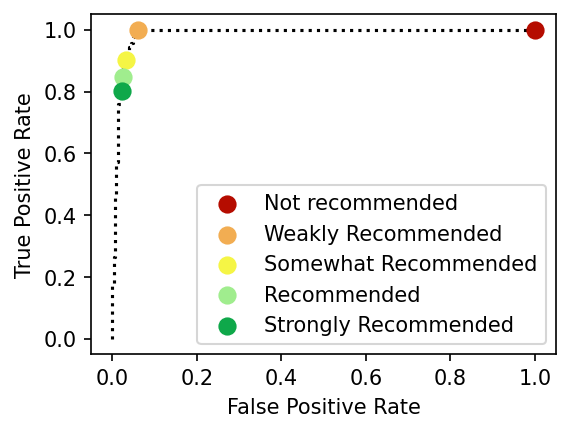

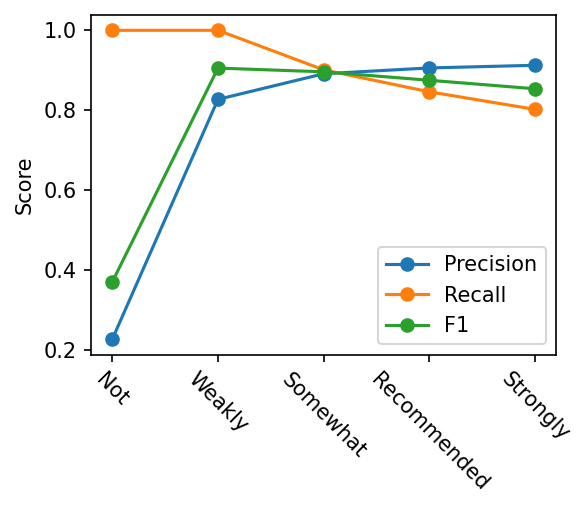

In [28]:
def make_pr_plots(true_labels, preds):
    thresholds = [0, .18, .35, .6, .75]
    

    precs = []
    recs = []
    f1s = []

    fp_rates = []
    tp_rates = []
    
   
    for thresh in thresholds:
        p, r, f, _ = precision_recall_fscore_support(true_labels, np.array(preds) > thresh)
        precs.append(p[1])
        recs.append(r[1])
        f1s.append(f[1])

        tp_rates.append(r[1])
        cats = confusion_matrix(true_labels, np.array(preds) > thresh).ravel()
        fp_rates.append(cats[1]/(cats[0]+cats[1]))
        
    print(precs)
    print(f1s)

    colors = ['#b50c00', '#f2ad52', '#f5f545', '#a0ed8e', '#0fa84a']


    plt.figure(dpi=150, figsize = (4,3))
    fpr, tpr, thresholds = roc_curve(true_labels, np.array(preds), pos_label=1)
    for i in range(5):
        plt.scatter(fp_rates[i], tp_rates[i], s = 60, zorder = 2, c = colors[i])
    plt.legend(['Not recommended', 'Weakly Recommended', 'Somewhat Recommended', "Recommended", 'Strongly Recommended'])
    plt.plot(fpr,tpr, c='k', linestyle='dotted', zorder = 1)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    print(auc(fpr,tpr))

    plt.figure(dpi = 150, figsize = (4,3))
    plt.plot(precs, marker = 'o')
    plt.plot(recs, marker = 'o')
    plt.plot(f1s, marker = 'o')
    
    plt.legend(['Precision', 'Recall', 'F1'])
    plt.gca().set_xticks([0,1,2,3,4])
    plt.gca().set_xticklabels(['Not', 'Weakly', 'Somewhat', "Recommended", 'Strongly'], rotation = -45)
    plt.ylabel('Score')
    
make_pr_plots(true_labels, inclusion_likelihoods)

In [29]:
#do people normally agree with the tool?


def get_votes_and_predictions(with_prediction, fake_only, single_person = None, density = False, alpha = 0.7, gamma = True, filter_clean = True, plot = True):
    votes = []
    predictions = []
    fn_with_kw = 0
    fn_total = 0
    
    tn_total = 0
    tn_with_kw = 0
    
    n_with_kw = 0
    n_total = 0
    p_with_kw = 0
    p_total = 0

    
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1

    if(single_person is not None):
        names_to_check = names[single_person: single_person + 1]
    else:
        names_to_check = names

    times = []

    for name in names_to_check:
#         query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}' and vote = 'YES'".format(name, INIT_DATE, END_DATE)
        query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE  AND created_at < '{}'".format(name, INIT_DATE, END_DATE)
        tab = create_pandas_table(query)
        tab['time_taken'] = tab['created_at'] - tab['created_at'].shift(1)
        tab = tab.loc[tab['had_abstract'] == True]
        tab = tab.loc[tab['has_prediction'] == with_prediction]
        tab = tab.loc[tab['time_taken'] > (datetime(2020,1,1) - datetime(2020, 1,1 ))]
        tab = tab.loc[tab['time_taken'] < (datetime(2020,1,1,1,2,1) - datetime(2020, 1,1,1,1,1))]
        
        if(filter_clean):
            tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
        if(fake_only):
            tab = tab.loc[tab['fake_review_id'].notnull()]
        
        if(len(tab) > 0):
            temp_prediction = []
            for i in range(len(tab)):
                title_hash = tab.iloc[i].title_hash
                prediction_query = "SELECT * FROM predictions WHERE title_hash = '{}'".format(title_hash)
                qtab = create_pandas_table(prediction_query)
                if(len(qtab) > 0):
                    inclusion_likelihood = qtab.iloc[0].inclusion_likelihood
                    temp_prediction.append(inclusion_likelihood)
                    
                    if(inclusion_likelihood <= 0.18 and tab.iloc[i].vote != 'NO'):
                        if(len(tab.iloc[i].keywords) > 0):
                            fn_total += 1
                            fn_with_kw += int(np.sum(tab.iloc[i].keyword_counts_in_abstract) > 0)
                            
                        
                    if(inclusion_likelihood <= 0.18 and tab.iloc[i].vote == 'NO'):
                        if(len(tab.iloc[i].keywords) > 0):
                            tn_total += 1
                            tn_with_kw += int(np.sum(tab.iloc[i].keyword_counts_in_abstract) > 0)

                            
                            
                            
                            
                    if(tab.iloc[i].vote != 'NO'):
                        if(len(tab.iloc[i].keywords) > 0):
                            p_total += 1
                            p_with_kw += int(np.sum(tab.iloc[i].keyword_counts_in_abstract) > 0)
                            
                        
                    if(tab.iloc[i].vote == 'NO'):
                        if(len(tab.iloc[i].keywords) > 0):
                            n_total += 1
                            n_with_kw += int(np.sum(tab.iloc[i].keyword_counts_in_abstract) > 0)
                            
                    
#                     if(len(tab.iloc[i].keyword_counts_in_abstract) > 0):
#                         print(tab.iloc[i].keywords)
                    
                else:
                    temp_prediction.append(np.nan)
                    
                    
            tab['prediction'] = temp_prediction

            tab = tab.loc[tab['prediction'].notna()]
#             print("SLKDFJS")
#             print((tab[-20:]["vote"]).tolist())

            votes.extend((tab["vote"] != 'NO'))
#             print((tab["vote"] != 'NO'))
            predictions.extend(tab['prediction'])
    
        
    print('Rate of having keywords in FN: {:.3f}, n_num, {}, n_denom, {}'.format(fn_with_kw/fn_total, fn_with_kw, fn_total))
    print('Rate of having keywords in TN: {:.3f}, n_num, {}, n_denom, {}'.format(tn_with_kw/tn_total, tn_with_kw, tn_total))
    
    print('Rate of having keywords in N: {:.3f}, n_num, {}, n_denom, {}'.format(n_with_kw/n_total, n_with_kw, n_total))
    print('Rate of having keywords in P: {:.3f}, n_num, {}, n_denom, {}'.format(p_with_kw/p_total, p_with_kw, p_total))
    
    print(stats.fisher_exact([[fn_with_kw, fn_total-fn_with_kw],[tn_with_kw, tn_total-tn_with_kw]]))
    print(stats.fisher_exact([[n_with_kw, n_total-n_with_kw],[p_with_kw, p_total-p_with_kw]]))
            
    
    
    
    return votes, predictions

# Operating Characterestics


With
Rate of having keywords in FN: 0.714, n_num, 10, n_denom, 14
Rate of having keywords in TN: 0.368, n_num, 402, n_denom, 1092
Rate of having keywords in N: 0.375, n_num, 419, n_denom, 1117
Rate of having keywords in P: 0.843, n_num, 107, n_denom, 127
(4.291044776119403, 0.010985300300216284)
(0.11220309027126904, 1.4345332829459897e-24)
Weak: TN: 2442, FP: 90, FN: 33, TP: 263
Meh: TN: 2499, FP: 33, FN: 67, TP: 229
Yeh: TN: 2515, FP: 17, FN: 87, TP: 209
Yeeeehhh: TN: 2528, FP: 4, FN: 109, TP: 187
[0.10466760961810467, 0.7450424929178471, 0.8740458015267175, 0.9247787610619469, 0.9790575916230366]
[0.18950064020486557, 0.8104776579352851, 0.8207885304659497, 0.8007662835249042, 0.7679671457905545]
0.956178482985355


C:\Users\Noel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


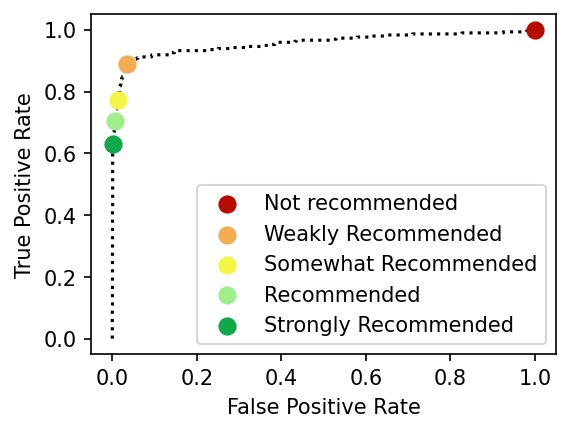

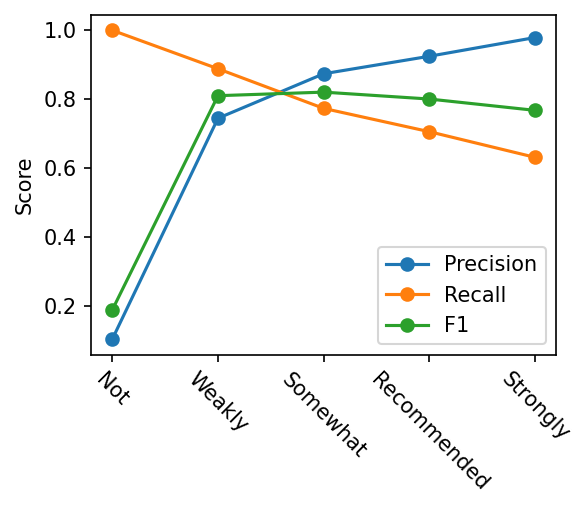

In [30]:
# print("Without")
# votes, prediction = get_votes_and_predictions(False, False, None, True)
# print("Weak: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.18).ravel()))
# print("Meh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.35).ravel()))
# print("Yeh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.6).ravel()))
# print("Yeeeehhh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.75).ravel()))

print()
print("With")
votes, prediction = get_votes_and_predictions(True, False, None, True)
print("Weak: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.18).ravel()))
print("Meh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.35).ravel()))
print("Yeh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.6).ravel()))
print("Yeeeehhh: TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.75).ravel()))

# print(precision_recall_fscore_support(votes, np.array(prediction) > 0.18))
# print(precision_recall_fscore_support(votes, np.array(prediction) > 0.35))
# print(precision_recall_fscore_support(votes, np.array(prediction) > 0.6))
# print(precision_recall_fscore_support(votes, np.array(prediction) > 0.75))


make_pr_plots(votes, prediction)

With
Rate of having keywords in FN: 0.333, n_num, 1, n_denom, 3
Rate of having keywords in TN: 0.368, n_num, 57, n_denom, 155
Rate of having keywords in N: 0.373, n_num, 59, n_denom, 158
Rate of having keywords in P: 0.793, n_num, 46, n_denom, 58
(0.8596491228070176, 1.0)
(0.155467720685112, 3.8836780419449486e-08)
TN: 502, FP: 28, FN: 8, TP: 165
TN: 520, FP: 10, FN: 24, TP: 149
TN: 526, FP: 4, FN: 32, TP: 141
TN: 528, FP: 2, FN: 38, TP: 135
[0.2460881934566145, 0.8549222797927462, 0.9371069182389937, 0.9724137931034482, 0.9854014598540146]
[0.39497716894977164, 0.9016393442622952, 0.897590361445783, 0.8867924528301886, 0.8709677419354838]
0.9847038935543679


C:\Users\Noel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


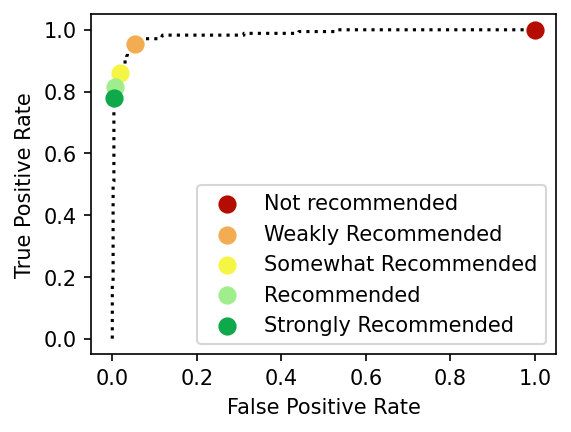

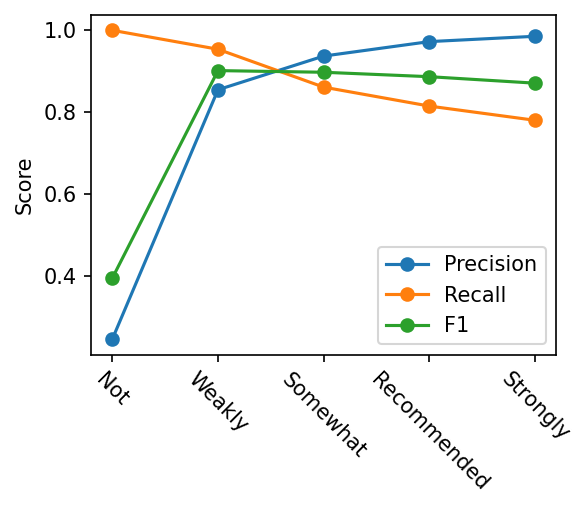

In [31]:
# print("Without")
# votes, prediction = get_votes_and_predictions(False, True, None, True)
# print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.18).ravel()))
# print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.35).ravel()))
# print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.6).ravel()))
# print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.75).ravel()))


print("With")
votes, prediction = get_votes_and_predictions(True, True, None, True)
print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.18).ravel()))
print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.35).ravel()))
print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.6).ravel()))
print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(votes, np.array(prediction) > 0.75).ravel()))

make_pr_plots(votes, prediction)

In [33]:
# # no tool
# hashes, true_labels, fulltext_predictions, included_predictions = get_conf_matrix(False, True, False)
# #tool
# # hashes, true_labels, fulltext_predictions, included_predictions = get_conf_matrix(True, True, False)

# for i in range(len(hashes)):
#     if(true_labels[i] == 1 and included_predictions[i] == 0):
#         title_hash = hashes[i]
# #         print("Title: {} \n index: {} \n prediction: {} \n".format(hash_to_label[title_hash]['title'], hash_to_label[title_hash]['index'], hash_to_label[title_hash]['prediction']))
#         info = hash_to_label[title_hash]
# #         print("Title: {} \nurl: {} \nabstract: {} \nindex: {} \nprediction: {} \n".format(info['title'], info['url'], info['abstract'], info['index'], info['prediction']))
#         print("Title: {} \nurl: {} \nindex: {} \nprediction: {} \n".format(info['title'], info['url'], info['index'], info['prediction']))

# Feature Usage

In [34]:
#UNDO USAGE

def get_undo_rate(with_prediction, fake_only, single_person = None, density = False, alpha = 0.7, gamma = True, filter_clean = True, plot = True):
    votes = []
    predictions = []
    n_total_votes = 0
    n_undo = 0
    n_undo_changes = 0

    
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1
    
    if(single_person is not None):
        names_to_check = names[single_person: single_person + 1]
    else:
        names_to_check = names

    times = []

    for name in names_to_check:
#         query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}' and vote = 'YES'".format(name, INIT_DATE, END_DATE)
        query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}'".format(name, INIT_DATE, END_DATE)
        tab = create_pandas_table(query)
        tab['time_taken'] = tab['created_at'] - tab['created_at'].shift(1)
        tab = tab.loc[tab['had_abstract'] == True]
        tab = tab.loc[tab['has_prediction'] == with_prediction]
        
        if(filter_clean):
            tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
        if(fake_only):
            tab = tab.loc[tab['fake_review_id'].notnull()]
            
        n_total_votes += len(tab.title_hash.unique())
        
        
        query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=TRUE AND created_at < '{}'".format(name, INIT_DATE, END_DATE)
        tab = create_pandas_table(query)
        tab = tab.loc[tab['had_abstract'] == True]
        tab = tab.loc[tab['has_prediction'] == with_prediction]
        
        if(filter_clean):
            tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
        if(fake_only):
            tab = tab.loc[tab['fake_review_id'].notnull()]
                        
            
        for i in range(len(tab)):
            title_hash = tab.iloc[i].title_hash
            query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=False AND created_at < '{}' AND title_hash = '{}'".format(name, INIT_DATE, END_DATE, title_hash)
            
            tab2 = create_pandas_table(query)
            
            if(tab2.iloc[0].vote != tab.iloc[i].vote):
                n_undo_changes += 1
            
        n_undo += len(tab.title_hash.unique())
        
    print(n_undo_changes)
            
        
    print('{}, {}, {}'.format(n_undo/n_total_votes, n_undo, n_total_votes))
            
    
    

In [35]:
# print("Without")
# get_undo_rate(False, False, None, True)

print("With")
get_undo_rate(True, False, None, True)

With
6
0.00732017823042648, 23, 3142


In [36]:
def get_usage_rate(with_prediction, fake_only, single_person = None, density = False, alpha = 0.7, gamma = True, filter_clean = True, plot = True, unique = False):
    votes = []
    predictions = []
    n_pio = 0
    n_inclusion = 0
    n_keyword = 0
    n_undo = 0
    n_keykey = 0
    n_total = 0

    
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1

    if(single_person is not None):
        names_to_check = names[single_person: single_person + 1]
    else:
        names_to_check = names

    times = []

    for name in names_to_check:
#         query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}' and vote = 'YES'".format(name, INIT_DATE, END_DATE)
        query = "SELECT * FROM abstract_screen_logs WHERE reviewer_name='{}' AND review_id=2821 AND is_full_text=FALSE AND was_tiebreak=FALSE AND created_at > '{}' AND was_undo=FALSE AND created_at < '{}'".format(name, INIT_DATE, END_DATE)
        tab = create_pandas_table(query)
        tab['time_taken'] = tab['created_at'] - tab['created_at'].shift(1)
        tab = tab.loc[tab['had_abstract'] == True]
        tab = tab.loc[tab['has_prediction'] == with_prediction]
        
        if(filter_clean):
            tab = tab[~tab['title_hash'].isin(extraction_excluded_hashes)]
        
        if(fake_only):
            tab = tab.loc[tab['fake_review_id'].notnull()]
            
        if(len(tab) == 0):
            continue
                        
        
        
        
        tab = tab.drop_duplicates('title_hash', keep = 'last')
        
        if(unique):
            n_total += 1
            n_inclusion += int(np.any(tab.show_inclusion_likelihood_on.tolist()))
            n_pio += int(np.any(tab.highlight_pio_on.tolist()))
            n_keyword += int(np.any(tab.highlight_keywords_on.tolist()))
            n_keykey += int(np.any(np.logical_and(tab.highlight_keywords_on.tolist(), [len(x) > 0 for x in tab.keywords.tolist()])))

        else:
            n_total += len(tab.title_hash.unique())
            n_inclusion += np.sum(tab.show_inclusion_likelihood_on.tolist())
            n_pio += np.sum(tab.highlight_pio_on.tolist())
            n_keyword += np.sum(tab.highlight_keywords_on.tolist())
            n_keykey += np.sum(np.logical_and(tab.highlight_keywords_on.tolist(), [len(x) > 0 for x in tab.keywords.tolist()]))
    
    
    print('inc: {}, pio: {}, key: {}, keykey: {}, total: {}'.format(n_inclusion, n_pio, n_keyword, n_keykey, n_total))
    print('inc: {}, pio: {}, key: {}, keykey: {}, total: {}'.format(n_inclusion/n_total, n_pio/n_total, n_keyword/n_total, n_keykey/n_total, n_total/n_total))
    
            
        
#     print('{}, {}, {}'.format(n_undo/n_total_votes, n_undo, n_total_votes))

In [37]:
print("With")
get_usage_rate(True, False, None, True, unique = True)

print()
get_usage_rate(True, False, None, True, unique = False)

With
inc: 7, pio: 5, key: 7, keykey: 3, total: 7
inc: 1.0, pio: 0.7142857142857143, key: 1.0, keykey: 0.42857142857142855, total: 1.0

inc: 3140, pio: 1918, key: 2079, keykey: 663, total: 3142
inc: 0.9993634627625716, pio: 0.6104392106938256, key: 0.661680458306811, keykey: 0.21101209420751113, total: 1.0


In [38]:
print("Without")
get_undo_rate(False, True, None, True)

print("With")
get_undo_rate(True, True, None, True)

Without
0
0.0, 0, 892
With
2
0.0036231884057971015, 3, 828


# OPOT Analysis

In [39]:
#These are additional votes gathered for OPOT analysis, which were not originally in the database.

opot_conflict_vote_dict = {
    "442de4f351dd7ac93afd93a2396cc348f8837df4fbe03d0b62e6d4986c7e8218":"NO",
    "d46e0a1a95a93773811a4c1b4cfbaea699af365689347d6ec7f557ceba4584ef":"YES",
    "96d911f69a450777d0fcaaf4a3cb27b21b8c9adc3de58e4f3717815063994d66":"YES",
    "956fcc76b89070d95eba22be40db3bb3eb0c45ce217ec11b6964aa0490d41d03":"NO",
    "9ae79c8ac4175cdd6798ad7d8517eef083260b13f45ea671efea4c210ad4ad6e":"NO",
    "42ebb0a99a8783e29cbf9bd276b16641f0fb6011ead898b868b58bd48fa723fa":"NO",
    "86b547636ff912ffac43ac33352602431058c7d2ca76bc0142ca96af507fc630":"YES",
    "d490bf683eccdc5d75cd91456e9ca318fa816513ce75e060fcc17e06f1803e54":"YES",
    "e9367403c6e987d6ed3dfb56b38377240c101077a3afa2eb9fe5d175ff508c28":"NO",
    "e177584e95aff5d6a30b01f3f0490172c46e4225871b4c379a6094e7e5ee2b1b":"YES",
    "ccff446464f941f1fead4d23fbb7f42daba36b8bff0a4ca492a0e158937bf015":"NO",
    "15be6f8f5d98ae530e20cc22e7a0fd386b468aadcc04cb1b85e0ce48b74e1306":"YES",
    "7d36734f5e7bd89bc435613cac21775b8b146c1dd4d7748c5e88e1c57fa0e204":"YES",
    "c3bca12cf419335b651a0b160a7c733b9cc949f81933c0f1fd348fb25ee060a4":"YES",
    "4e19632bba955b508f94029d7f8e28efb94264a348e89297da99377c32cd5586":"NO",
    "b16cc8e824866ab28640cbb44e1f79e4011c22a031d56a8bafb34880769d61ef":"YES"
}

opot_ft_results_dict = {
    '15be6f8f5d98ae530e20cc22e7a0fd386b468aadcc04cb1b85e0ce48b74e1306': 'INCLUDE',
    '7d36734f5e7bd89bc435613cac21775b8b146c1dd4d7748c5e88e1c57fa0e204': 'EXCLUDE',
    '86b547636ff912ffac43ac33352602431058c7d2ca76bc0142ca96af507fc630': 'INCLUDE',
    '96d911f69a450777d0fcaaf4a3cb27b21b8c9adc3de58e4f3717815063994d66': 'EXCLUDE',
    'b16cc8e824866ab28640cbb44e1f79e4011c22a031d56a8bafb34880769d61ef': 'INCLUDE',
    'c3bca12cf419335b651a0b160a7c733b9cc949f81933c0f1fd348fb25ee060a4': 'INCLUDE',
    'd46e0a1a95a93773811a4c1b4cfbaea699af365689347d6ec7f557ceba4584ef': 'INCLUDE',
    'd490bf683eccdc5d75cd91456e9ca318fa816513ce75e060fcc17e06f1803e54': 'INCLUDE',
    'e177584e95aff5d6a30b01f3f0490172c46e4225871b4c379a6094e7e5ee2b1b': 'INCLUDE',
    'ae9a637fdc3abcc9682f9f9d2b27986e381dd4952844b54802a37baae94233b5': 'INCLUDE',
    'c5fe976d677de0f488ac47c8aa908455d7323828b64f4c3a8ab429148e2bb82b': 'EXCLUDE',
    '4e19632bba955b508f94029d7f8e28efb94264a348e89297da99377c32cd5586': 'EXCLUDE', 
    '956fcc76b89070d95eba22be40db3bb3eb0c45ce217ec11b6964aa0490d41d03': 'EXCLUDE', 
    'ccff446464f941f1fead4d23fbb7f42daba36b8bff0a4ca492a0e158937bf015': 'EXCLUDE', 
    'e9367403c6e987d6ed3dfb56b38377240c101077a3afa2eb9fe5d175ff508c28': 'EXCLUDE', 
    '442de4f351dd7ac93afd93a2396cc348f8837df4fbe03d0b62e6d4986c7e8218': 'EXCLUDE', 
    '9ae79c8ac4175cdd6798ad7d8517eef083260b13f45ea671efea4c210ad4ad6e': 'EXCLUDE'
}

In [40]:
def filter_votes_opot(tab, tool_only = False):
    title_hash_to_votes = {}

    total = len(tab.title_hash.unique())
    
#     print(len(tab))
    tab = tab.sort_values(by=['was_tiebreak'])
    
    if(not tool_only):
        for i in range(len(tab)):
            vote = tab.iloc[i]
            if not vote['title_hash'] in title_hash_to_votes and (vote.reviewer_name in reviewer_must_vote_names) and not vote.was_tiebreak:
                title_hash_to_votes[vote['title_hash']] = {}

                title_hash_to_votes[vote['title_hash']][vote['reviewer_name']] = {
                    'vote': not (vote.vote == 'NO' or vote.vote == 'EXCLUDE'),
                    'must_vote': vote.reviewer_name in reviewer_must_vote_names,
                    'is_tie_break': vote.was_tiebreak,
                    'created_at': vote.created_at,
                    'reviewer_name': vote.reviewer_name
                }

        for i in range(len(tab)):
            vote = tab.iloc[i]
            if not vote['title_hash'] in title_hash_to_votes and not vote.was_tiebreak:
                title_hash_to_votes[vote['title_hash']] = {}
            #tie breaks will always go after normal votes
                title_hash_to_votes[vote['title_hash']][vote['reviewer_name']] = {
                    'vote': not (vote.vote == 'NO' or vote.vote == 'EXCLUDE'),
                    'must_vote': vote.reviewer_name in reviewer_must_vote_names,
                    'is_tie_break': vote.was_tiebreak,
                    'created_at': vote.created_at,
                    'reviewer_name': vote.reviewer_name
                }
    
    for title_hash, abstract_info in  hash_to_label.items():
        if not title_hash in title_hash_to_votes:
            if(tool_only):
                title_hash_to_votes[title_hash] = {}
                
        title_hash_to_votes[title_hash]['tool'] = {
            'vote': hash_to_label[title_hash]['prediction'] > 0.18,
            'must_vote': False,
            'is_tie_break': False,
            'created_at': -1,
            'reviewer_name': 'tool'
        }
    
        if(tool_only):
            title_hash_to_votes[title_hash]['tool2'] = {
                'vote': hash_to_label[title_hash]['prediction'] > 0.18,
                'must_vote': False,
                'is_tie_break': False,
                'created_at': -1,
                'reviewer_name': 'tool2'
            }
    
    if(not tool_only):
        for i in range(len(tab)):
            vote = tab.iloc[i]
            if vote.was_tiebreak:
                thtv = title_hash_to_votes[vote['title_hash']]
                keys = list(thtv.keys())
                if thtv[keys[0]]['vote'] != thtv[keys[1]]['vote']:
                    title_hash_to_votes[vote['title_hash']][vote['reviewer_name']] = {
                        'vote': not (vote.vote == 'NO' or vote.vote == 'EXCLUDE'),
                        'must_vote': vote.reviewer_name in reviewer_must_vote_names,
                        'is_tie_break': vote.was_tiebreak,
                        'created_at': vote.created_at,
                        'reviewer_name': vote.reviewer_name
                    }

        for title_hash, vote in opot_conflict_vote_dict.items():
            if(not any([vote_info['is_tie_break'] for vote_info in title_hash_to_votes[title_hash].values()])):
                title_hash_to_votes[title_hash]['Mercedes Yanes Lane'] = {
                    'vote': not (vote == 'NO' or vote == 'EXCLUDE'),
                    'must_vote': True,
                    'is_tie_break': True,
                    'created_at': -1,
                    'reviewer_name': 'Mercedes Yanes Lane'
                }

    one_vote = 0
    conflicts = 0
    included = 0
    excluded = 0

    conflict_dict = {}
    done_set = set()
    included_set = set()
    already_screened_set = set()
    cant_screen_set = set()

    reviewer_name = 'notarealperson'
    must_vote = False


    for title_hash, vote in title_hash_to_votes.items():
        if(any([vote_info['is_tie_break'] for vote_info in vote.values()])): #tie break
            for vote_info in vote.values():
                if(vote_info['is_tie_break']):
                    done_set.add(title_hash)
                    if(vote_info['vote']):
                        included_set.add(title_hash)
                        included += 1
        else:
            if(len(vote.keys()) > 2): #weird edge case if more than 2 votes, pick first two votes by 'must vote' people
                vote_info_list = sorted(vote.values(), key = lambda x: x['created_at'])
                vote = {}
                #take the first must vote
                for vote_info in vote_info_list:
                    if(vote_info['must_vote']):
                        vote[vote_info['reviewer_name']] = vote_info
                        vote_info_list.remove(vote_info)
                        break
                #take the first item
                vote[vote_info_list[0]['reviewer_name']] = vote_info_list[0]

            if(len(vote.keys()) == 2): #two votes, check if a conflict needs to be resolved or not
                vote_info_list = list(vote.values())
                if(vote_info_list[0]['vote'] == vote_info_list[1]['vote'] and vote_info_list[0]['vote']):
                    done_set.add(title_hash)
                    included_set.add(title_hash)
                    
                    included += 1
                elif(vote_info_list[0]['vote'] == vote_info_list[1]['vote']):
                    done_set.add(title_hash)
                else:
                    conflicts += 1
                    reviewer_names = list(vote.keys())
                    conflict_dict[title_hash] = reviewer_names
            else: #one vote, zero votes can't be in the list
                one_vote += 1
                if(reviewer_name not in vote): #make sure this person hasn't already voted
                    if(list(vote.keys())[0] not in reviewer_must_vote_names and not must_vote):
                        cant_screen_set.add(title_hash)
                else:
                    already_screened_set.add(title_hash)

    done = len(done_set)
    screen = total - done - conflicts - len(cant_screen_set) - len(already_screened_set)
    no_vote = total - done - one_vote - conflicts
    resolve = conflicts

    vote_categories =  {
        'done': done,
        'one_vote': one_vote,
        'no_vote': no_vote,
        'conflicts': conflicts,
        'resolve': resolve,
        'screen': screen,
        'total': total,
        'included': included,
        'excluded': done-included        
    }
        

    conflict_hashes = conflict_dict.keys()
    
    print(conflict_hashes)
    
#     print(vote_categories)
    return vote_categories, included_set, set(tab.title_hash.unique().tolist())

def get_full_texts_opot(with_prediction, fake_only, filter_clean = True, tool_only = False):
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1
    
#     abstract_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=FALSE AND fake_review_id IN (10,11)"
    abstract_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=FALSE AND created_at > '{}' AND (created_at < '{}' {})".format(INIT_DATE, END_DATE, 
        "OR (created_at < '{}' AND fake_review_id IS NOT NULL)".format(INIT_DATE2) if not with_prediction else ' OR fake_review_id IS NOT NULL')
    
    tab = create_pandas_table(abstract_votes_query)
    tab = tab.loc[tab['had_abstract'] == True]
    tab = tab.loc[tab['has_prediction'] == with_prediction]
#     tab = tab.loc[tab['reviewer_name'] != 'reviewer1']
    
    if(fake_only):
        tab = tab.loc[tab['fake_review_id'].notnull()]
    
    cat, included_set, _ = filter_votes_opot(tab, tool_only = tool_only)
    print(cat)
    
    return included_set
    
def get_new_confusion_matrix_opot(with_prediction, fake_only, included_set, cleaned = True, show = True, print_latex_tab = False):
    if(with_prediction):
        INIT_DATE = INIT_DATE2
        END_DATE = END_DATE2
    else:
        INIT_DATE = INIT_DATE1
        END_DATE = END_DATE1
    
    fulltext_votes_query = "SELECT * FROM abstract_screen_logs WHERE review_id=2821 AND is_full_text=TRUE AND created_at > '{}' AND (created_at < '{}' {})".format(INIT_DATE, END_DATE, 
        "OR (created_at < '{}' AND fake_review_id IS NOT NULL)".format(INIT_DATE2) if not with_prediction else ' OR fake_review_id IS NOT NULL')
    
    
    tab = create_pandas_table(fulltext_votes_query)
    tab = tab.loc[tab['had_abstract'] == True]
    tab = tab.loc[tab['has_prediction'] == with_prediction]
        
    
    
    tab = tab[tab['title_hash'].isin(included_set)]
        
        
    tab = tab.loc[tab['reviewer_name'] != 'reviewer1']
    
    if(fake_only):
        tab = tab.loc[tab['fake_review_id'].notnull()]
            
    print(included_set - (set(opot_ft_results_dict.keys()).union(set(tab.title_hash.unique().tolist()))))
    
    for title_hash in set(opot_ft_results_dict.keys())-set(tab.title_hash.unique().tolist()) & included_set:
        tab = tab.append({
            'title_hash': title_hash,
            'vote': opot_ft_results_dict[title_hash],
            'reviewer_name': 'Mercedes Yanes Lane',
            'was_tiebreak': True
        }, ignore_index = True)  
        
        print(opot_ft_results_dict[title_hash])
        
        
        
    cat, included_set, fulltext_set = filter_votes(tab)
    
    hashes = []
    true_labels = []
    fulltext_predictions = []
    included_predictions = []
    inclusion_likelihoods = []
    
    for title_hash, label_info in hash_to_label.items():
        hashes.append(title_hash)
        true_labels.append(label_info['cleaned'] if cleaned else label_info['uncleaned'])
        inclusion_likelihoods.append(label_info['prediction'])
        fulltext_predictions.append(int(title_hash in fulltext_set))
        included_predictions.append(int(title_hash in included_set))
        
        if(title_hash in included_set and not label_info['cleaned']):
            print(label_info['title'])
    
        
    if(show):
        print()
        print("Included:")
        print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, included_predictions).ravel()))
        print()
        print("Made to full text review:")
        print("TN: {}, FP: {}, FN: {}, TP: {}".format(*confusion_matrix(true_labels, fulltext_predictions).ravel()))
        print(precision_recall_fscore_support(true_labels, fulltext_predictions))
        
    if(print_latex_tab):
        lat_tab(true_labels, included_predictions)
        lat_tab(true_labels, fulltext_predictions)
    print(cat)
#     print('Full text inclusion rate: {:.2f}%, n_num: {}, n_den: {}'.format(cat['included']/cat['done'] * 100, cat['included'], cat['done']))

In [41]:
included_set = get_full_texts_opot(False, True, False)
print(len(included_set))
# print(len(included_set))
get_new_confusion_matrix_opot(False, True, included_set, print_latex_tab = True)

dict_keys([])
{'done': 400, 'one_vote': 0, 'no_vote': 0, 'conflicts': 0, 'resolve': 0, 'screen': 0, 'total': 400, 'included': 95, 'excluded': 305}
95
set()
INCLUDE
INCLUDE
INCLUDE
EXCLUDE
INCLUDE
EXCLUDE
Suboptimal personal protective equipment and SARS-CoV-2 infection in Nephrologists: a Spanish national survey.
Identification of natural SARS-CoV-2 infection in seroprevalence studies among vaccinated populations
Association between self-reported signs and symptoms and SARS-CoV-2 antibody detection in UK key workers.
Prevalence of COVID-19 Virus Infection in Semnan province.
Frequency of symptoms and asymptomatic SARS-CoV-2 infection in New Orleans, Louisiana
Seroprevalence of anti-SARS-CoV-2 antibodies among school and daycare children and personnel: Protocol for a cohort study in Montreal, Canada
COVID-19 prevalence among COVID-19 exposed health care workers at a tertiary care center in San Bernardino County, CA
Application of a SARS-CoV-2-specific serologic assay for translational r

In [42]:
included_set = get_full_texts_opot(True, True, False, tool_only = True)
get_new_confusion_matrix_opot(True, True, included_set, print_latex_tab = True)


dict_keys([])
{'done': 400, 'one_vote': 0, 'no_vote': 0, 'conflicts': 0, 'resolve': 0, 'screen': 0, 'total': 400, 'included': 110, 'excluded': 290}
set()
EXCLUDE
INCLUDE
INCLUDE
INCLUDE
INCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
EXCLUDE
Suboptimal personal protective equipment and SARS-CoV-2 infection in Nephrologists: a Spanish national survey.
Identification of natural SARS-CoV-2 infection in seroprevalence studies among vaccinated populations
Association between self-reported signs and symptoms and SARS-CoV-2 antibody detection in UK key workers.
Prevalence of COVID-19 Virus Infection in Semnan province.
Seroprevalence of anti-SARS-CoV-2 antibodies among school and daycare children and personnel: Protocol for a cohort study in Montreal, Canada
Application of a SARS-CoV-2-specific serologic assay for translational research and surveillance
SARS-CoV-2 among inmates over 60 years of age during a COVID-19 outbreak in a penitentiary complex in Brazil: positive health outcomes despit